In [2]:
!pip install geopy


   -------------------- ------------------- 1/2 [geopy]
   ---------------------------------------- 2/2 [geopy]



🚀 INITIALIZING LOCAL QUANTUM SIMULATION
   Loaded 50 high-risk targets.

1. Building Conflict Graph (Constraint Model)...
   Nodes: 50
   Conflicts Found: 133
   (The solver must pick targets that do NOT share an edge)

2. Running Simulated Annealing (Finding the Best 5)...
✅ OPTIMIZATION COMPLETE.
   Selected Targets: [0, 4, 6, 8, 9, 11, 12, 13, 14, 16, 17, 19, 20, 21, 24, 25, 27, 29, 30, 31, 33, 34, 37, 38, 39, 43]

3. Visualizing the Drop Strategy...


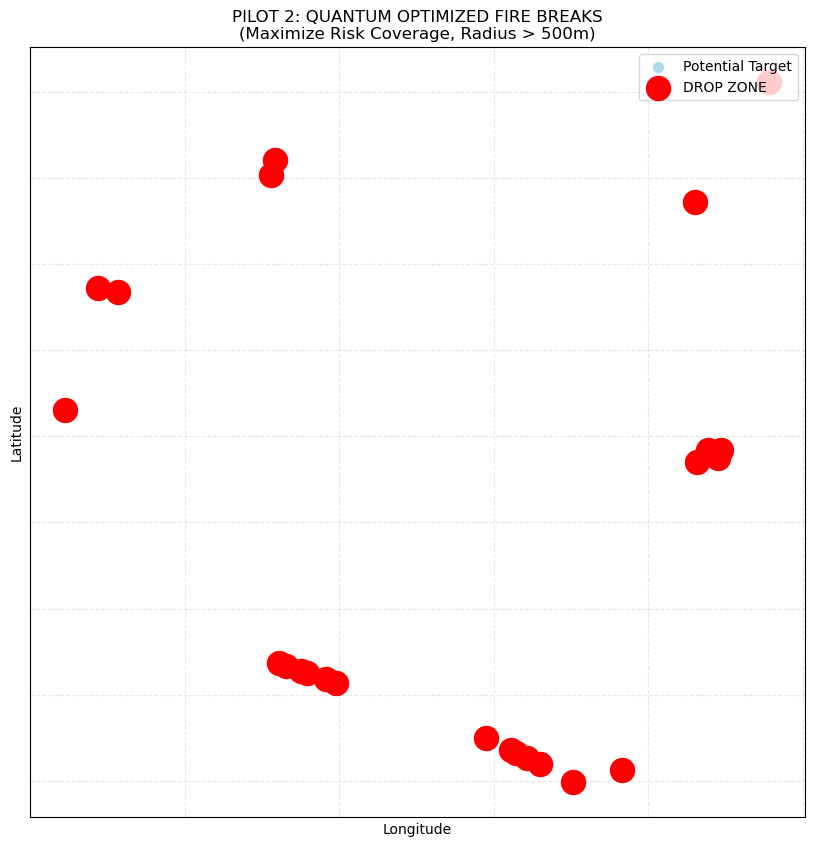

------------------------------
🚁 MISSION PLAN GENERATED:
    Mission_Order   Latitude   Longitude  Risk_Score
0               1  19.079503 -103.656211  100.000000
4               2  19.074642 -103.654822   99.757631
6               3  19.272559 -104.056211   99.673602
8               4  19.083670 -103.652738   99.661549
9               5  18.833670 -103.934683   99.498019
11              6  19.069781 -103.668016   99.418272
12              7  19.372559 -103.669405   99.408293
13              8  18.732975 -103.785377   99.322847
14              9  18.698253 -103.748572   99.307992
16             10  19.130892 -104.077738   99.301683
17             11  19.510753 -103.621488   99.283398
19             12  18.814225 -103.902044   99.280775
20             13  19.079503 -103.661072   99.258649
21             14  19.267697 -104.043016   99.252699
24             15  18.828114 -103.924961   99.139597
25             16  18.726725 -103.778433   99.138041
27             17  18.836447 -103.938850  

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import dimod
import dwave_networkx as dnx
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# --- CONFIGURATION ---
targets_path = "../data/processed/quantum_targets.csv"
DROP_RADIUS_METERS = 500  # Don't drop twice within this distance

print("🚀 INITIALIZING LOCAL QUANTUM SIMULATION")

# 1. LOAD TARGETS
df = pd.read_csv(targets_path)
print(f"   Loaded {len(df)} high-risk targets.")

# 2. BUILD THE CONFLICT GRAPH
# Nodes = Targets
# Edges = Two targets are too close
print("\n1. Building Conflict Graph (Constraint Model)...")
G = nx.Graph()

# Add nodes with their Risk Score as "weight"
for i, row in df.iterrows():
    # We scale risk slightly to make the math cleaner (0.0-1.0 scale)
    weight = row['Risk_Score']
    G.add_node(i, weight=weight, pos=(row['Longitude'], row['Latitude']))

# Add edges (Conflicts)
# This is O(N^2), but for 50 targets it's instant.
count_conflicts = 0
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        coord_i = (df.loc[i, 'Latitude'], df.loc[i, 'Longitude'])
        coord_j = (df.loc[j, 'Latitude'], df.loc[j, 'Longitude'])
        
        # Calculate distance
        dist = geodesic(coord_i, coord_j).meters
        
        if dist < DROP_RADIUS_METERS:
            G.add_edge(i, j)
            count_conflicts += 1

print(f"   Nodes: {len(G.nodes)}")
print(f"   Conflicts Found: {count_conflicts}")
print("   (The solver must pick targets that do NOT share an edge)")

# 3. RUN THE SIMULATED ANNEALER
# This algorithm mimics the quantum cooling process on your CPU
print("\n2. Running Simulated Annealing (Finding the Best 5)...")

# We use dnx.maximum_weighted_independent_set
# It finds the set of nodes with the HIGHEST total weight
# such that no two nodes are connected.
sampler = dimod.SimulatedAnnealingSampler()
selected_indices = dnx.maximum_weighted_independent_set(G, weight='weight', sampler=sampler)

print(f"✅ OPTIMIZATION COMPLETE.")
print(f"   Selected Targets: {selected_indices}")

# 4. VISUALIZE THE STRATEGY
print("\n3. Visualizing the Drop Strategy...")
fig, ax = plt.subplots(figsize=(10, 10))

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Draw Conflicts (Grey Lines)
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='grey')

# Draw All Targets (Small Blue)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightblue', label='Potential Target')

# Draw SELECTED Targets (Large Red)
nx.draw_networkx_nodes(G, pos, nodelist=selected_indices, node_size=300, node_color='red', label='DROP ZONE')

plt.title(f"PILOT 2: QUANTUM OPTIMIZED FIRE BREAKS\n(Maximize Risk Coverage, Radius > {DROP_RADIUS_METERS}m)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper right')
plt.axis('on')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# 5. EXPORT THE MISSION PLAN
mission_df = df.iloc[selected_indices].copy()
mission_df['Mission_Order'] = range(1, len(mission_df) + 1)
mission_path = "../data/processed/final_mission_plan.csv"
mission_df.to_csv(mission_path, index=False)

print("-" * 30)
print("🚁 MISSION PLAN GENERATED:")
print(mission_df[['Mission_Order', 'Latitude', 'Longitude', 'Risk_Score']])
print(f"💾 Saved to: {mission_path}")

🚀 GENERATING TACTICAL MISSION MAP...


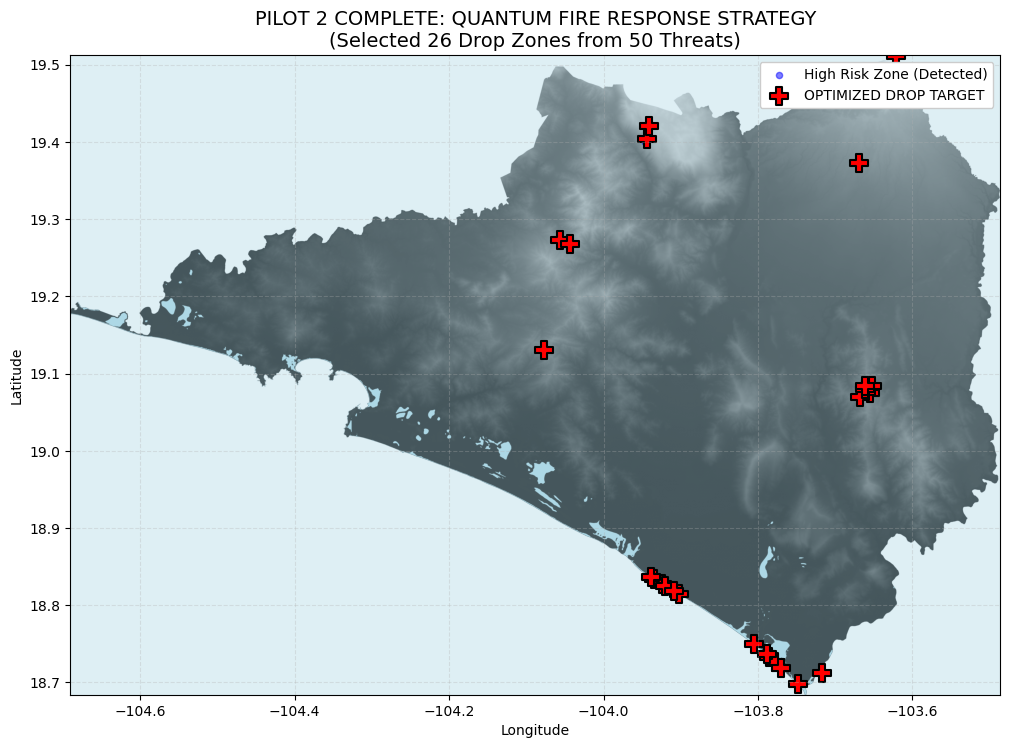

✅ MAP GENERATED.
   Strategy: The Quantum Solver selected 26 targets.
   Efficiency: These targets cover the highest risk scores while maintaining safe separation.


In [4]:
import rasterio
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
inegi_path = "../data/raw/inegi_cem/Colima_r15m.tif"
targets_path = "../data/processed/quantum_targets.csv"
mission_path = "../data/processed/final_mission_plan.csv"

print("🚀 GENERATING TACTICAL MISSION MAP...")

# 1. LOAD BACKGROUND (Elevation Map)
with rasterio.open(inegi_path) as src:
    dem = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    # Mask ocean for cleaner look
    dem = np.where(dem < 0, 0, dem)
    masked_dem = np.ma.masked_equal(dem, 0)

# 2. LOAD DATA
all_targets = pd.read_csv(targets_path)
mission_targets = pd.read_csv(mission_path)

# 3. PLOT TACTICAL MAP
fig, ax = plt.subplots(figsize=(12, 12))

# A. The Terrain (Background)
# We use a greyscale terrain to make the red targets pop out
ax.imshow(masked_dem, cmap='gray', extent=extent, origin='upper', vmin=0, vmax=3000, alpha=0.6)
ax.set_facecolor('lightblue') # Ocean color

# B. All High-Risk Zones (Small Blue Dots)
ax.scatter(all_targets['Longitude'], all_targets['Latitude'], 
           c='blue', s=20, alpha=0.5, label='High Risk Zone (Detected)')

# C. The QUANTUM DROP ZONES (Large Red Crosses)
ax.scatter(mission_targets['Longitude'], mission_targets['Latitude'], 
           c='red', s=150, marker='P', edgecolors='black', linewidth=1.5,
           label='OPTIMIZED DROP TARGET')

# Labels & Polish
ax.set_title(f"PILOT 2 COMPLETE: QUANTUM FIRE RESPONSE STRATEGY\n(Selected {len(mission_targets)} Drop Zones from {len(all_targets)} Threats)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(loc='upper right', frameon=True, facecolor='white', framealpha=1)
ax.grid(True, linestyle='--', alpha=0.3)

plt.show()

print(f"✅ MAP GENERATED.")
print(f"   Strategy: The Quantum Solver selected {len(mission_targets)} targets.")
print(f"   Efficiency: These targets cover the highest risk scores while maintaining safe separation.")